# Client Clustering 

In [59]:
#pip install yellowbrick
#pip install data-science-utils

In [2]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d


# Preprocesado y modelado
# ==============================================================================
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

#from sklearn import metrics
from sklearn.cluster import KMeans, DBSCAN
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Calidad de los clusters
# ==============================================================================
from ds_utils.unsupervised import plot_cluster_cardinality, plot_cluster_magnitude, plot_magnitude_vs_cardinality
from scipy.spatial.distance import euclidean

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Dataset

In [3]:
df = pd.read_csv("../data/application_record.csv")
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


## EDA

In [62]:
# How many rows and columns do we have.
df.shape

(438557, 18)

#### Nulls 

In [84]:
# Null data in our dataframe.
df.isnull().sum()

ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
OCCUPATION_TYPE        0
CNT_FAM_MEMBERS        0
dtype: int64

#### Duplicated 

In [64]:
# Duplicated data in our dataframe.

df.duplicated().sum()

0

In this case, we see that we don't have any duplicated data. Instead, we have nulls in our data that we must handle before doing our clients clustering 🧽

### Outliers 

In [65]:
df_num = df.select_dtypes(include = np.number )

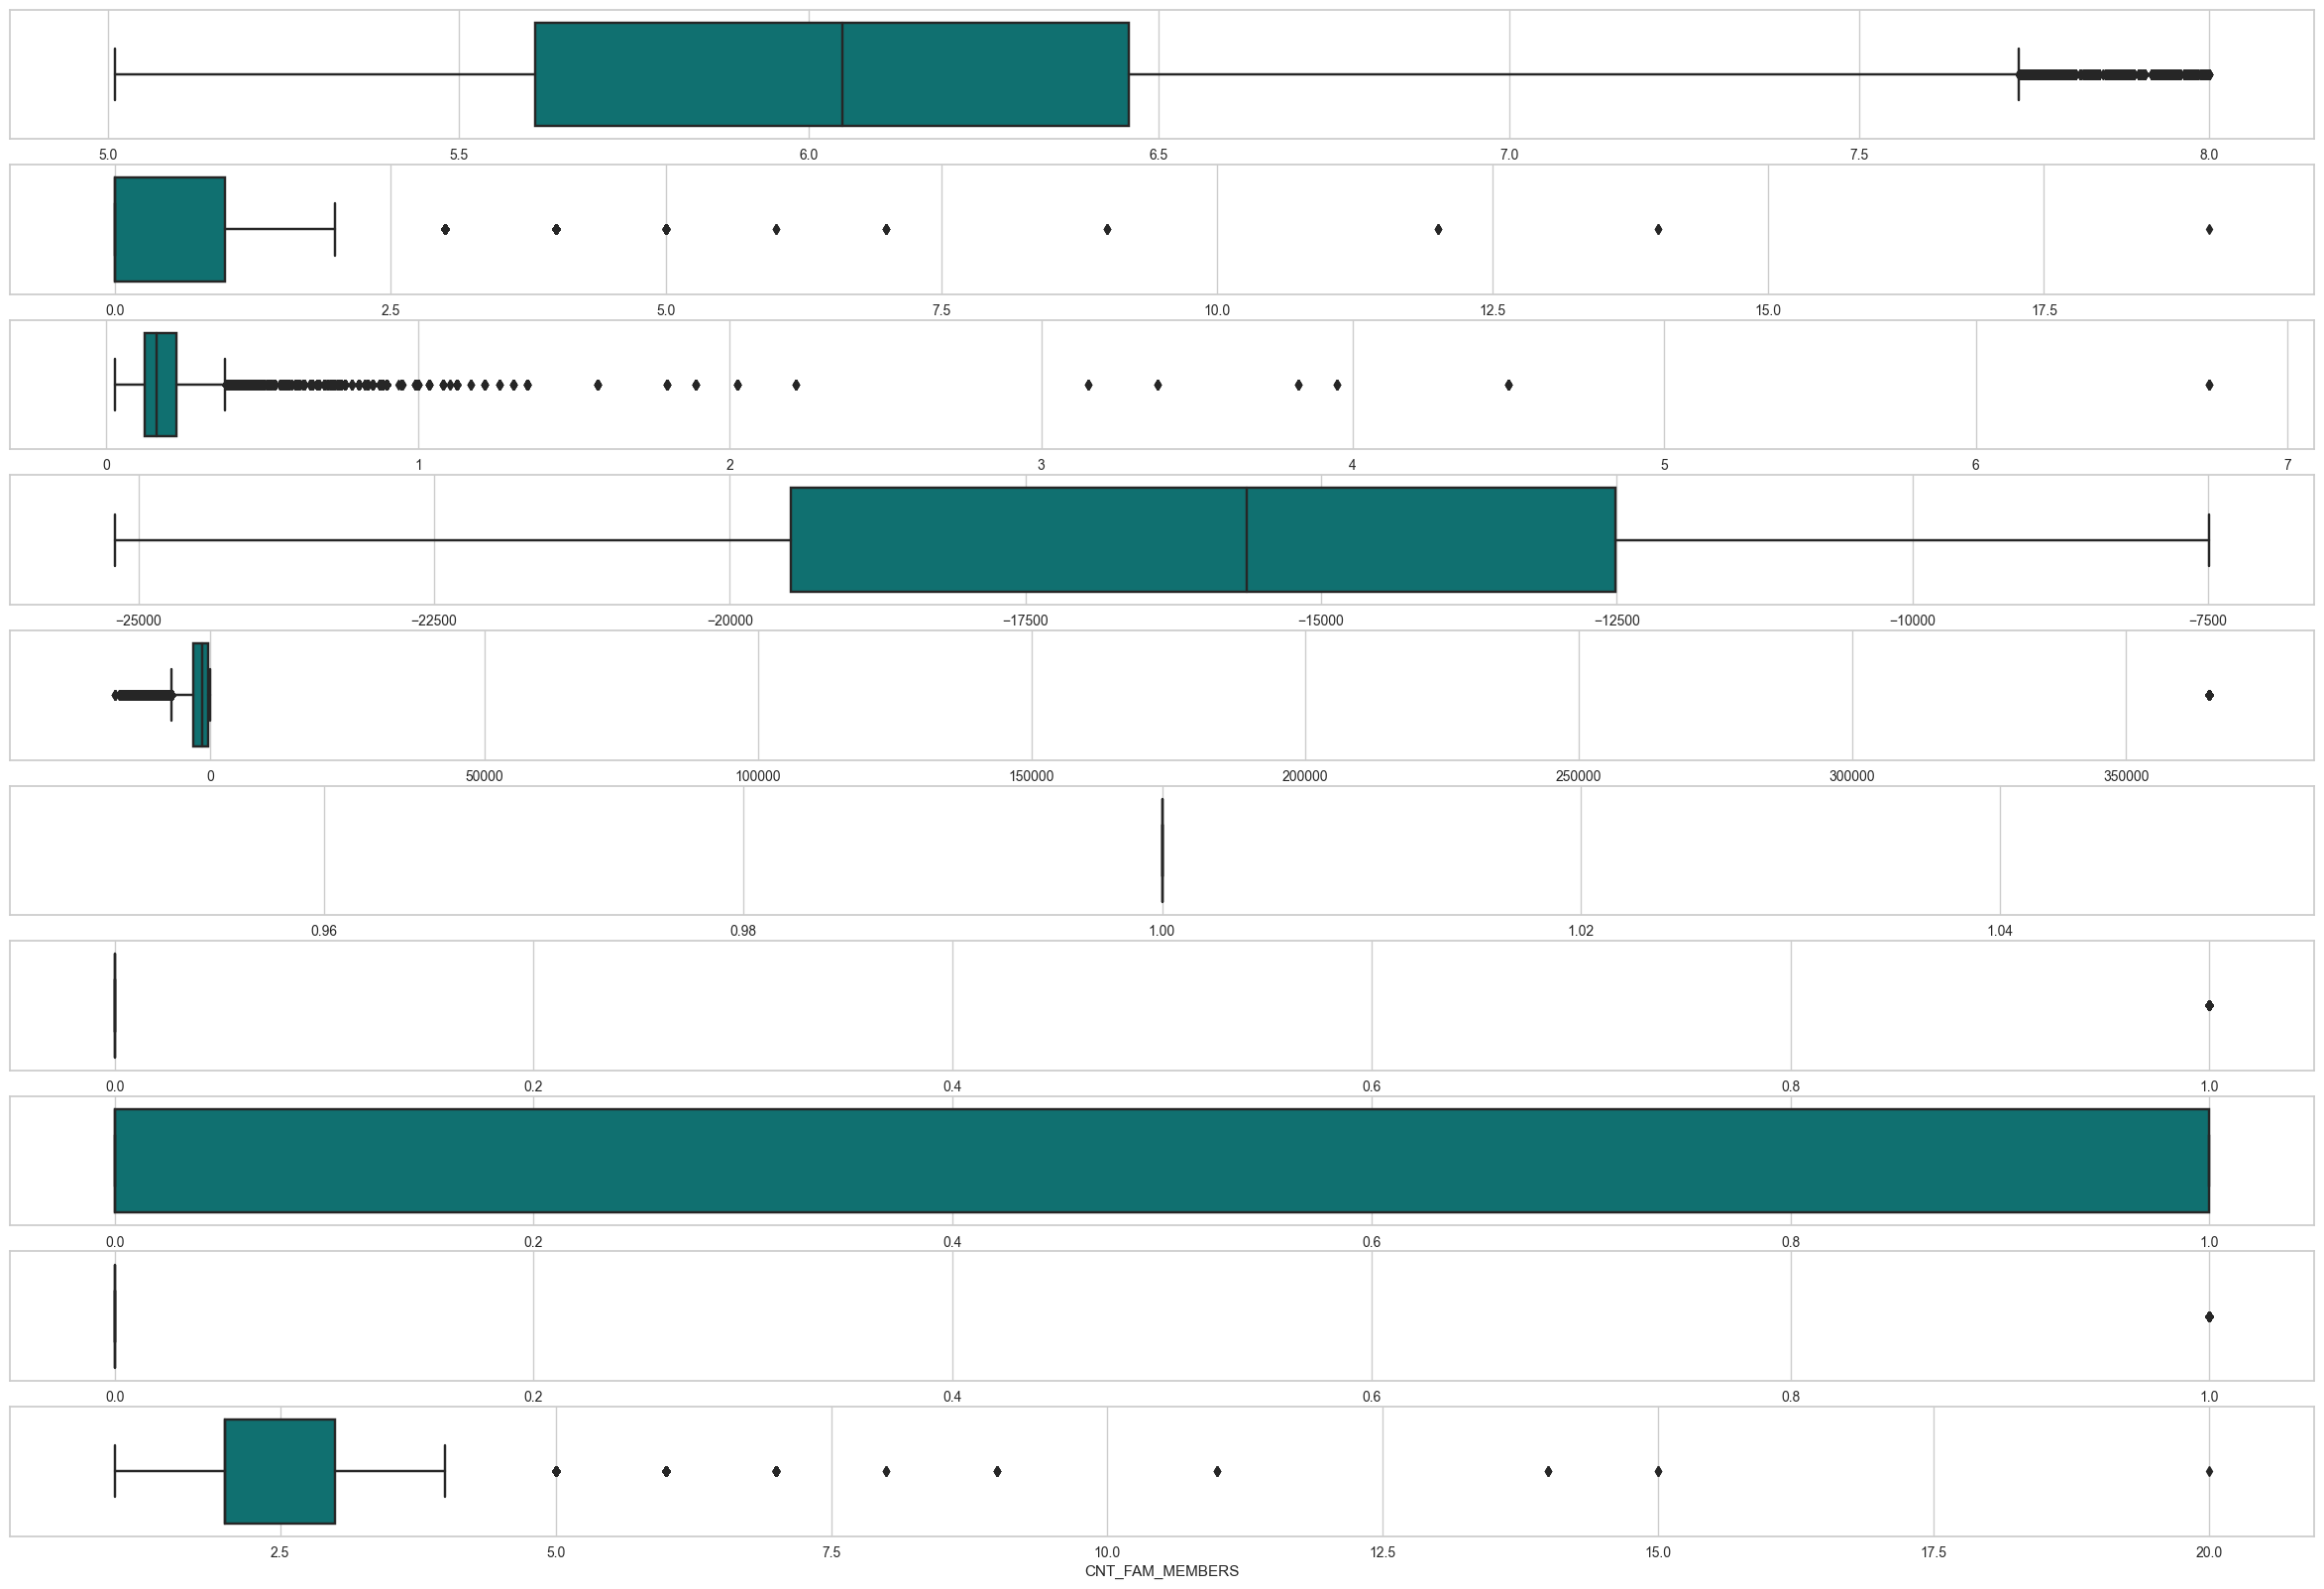

In [66]:
fig, ax = plt.subplots(10, 1, figsize=(30,20))

for i in range(len(df_num.columns)):
    sns.boxplot(x=df_num.columns[i], data=df_num, ax=ax[i], color = "teal")
plt.show()

#### Managing null data 

In [4]:
df= df.replace(np.nan,"null")

In [5]:
df["NAME_INCOME_TYPE"].unique()

array(['Working', 'Commercial associate', 'Pensioner', 'State servant',
       'Student'], dtype=object)

In [6]:
def null_replace(occupation_type, income_type):
    if occupation_type != "null":
        return occupation_type
    else:
        if income_type == "Pensioner":
            return "Pensioner"
        elif income_type == "Student":
            return "Student"
        else:
            return "null"

In [7]:
df["OCCUPATION_TYPE"] = df.apply(lambda dataframe: null_replace(dataframe["OCCUPATION_TYPE"], dataframe["NAME_INCOME_TYPE"]), axis = 1)

In [8]:
df["OCCUPATION_TYPE"].unique()

array(['null', 'Security staff', 'Sales staff', 'Pensioner',
       'Accountants', 'Laborers', 'Managers', 'Drivers', 'Core staff',
       'High skill tech staff', 'Cleaning staff', 'Private service staff',
       'Cooking staff', 'Low-skill Laborers', 'Medicine staff',
       'Secretaries', 'Waiters/barmen staff', 'HR staff', 'Realty agents',
       'IT staff', 'Student'], dtype=object)

In [12]:
def second_null_replace(occupation_type, employment):
    if occupation_type != "null":
        return occupation_type
    else:
        if employment > 0:
            return "Unemployed"
        else:
            return "Unknown"

In [13]:
df["OCCUPATION_TYPE"] = df.apply(lambda dataframe: second_null_replace(dataframe["OCCUPATION_TYPE"], dataframe['DAYS_EMPLOYED']), axis = 1)

In [14]:
df["OCCUPATION_TYPE"].unique()

array(['Unknown', 'Security staff', 'Sales staff', 'Pensioner',
       'Accountants', 'Laborers', 'Managers', 'Drivers', 'Core staff',
       'High skill tech staff', 'Cleaning staff', 'Private service staff',
       'Cooking staff', 'Low-skill Laborers', 'Medicine staff',
       'Secretaries', 'Waiters/barmen staff', 'HR staff', 'Realty agents',
       'IT staff', 'Student'], dtype=object)

In [15]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Unknown,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Unknown,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


#### Last Changes Before Encoding

In [16]:
df["DAYS_BIRTH"]= (df["DAYS_BIRTH"]/-365).round()
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,33.0,-4542,1,1,0,0,Unknown,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,33.0,-4542,1,1,0,0,Unknown,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,59.0,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52.0,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52.0,-3051,1,0,1,1,Sales staff,1.0


In [17]:
df["DAYS_EMPLOYED"]= (df["DAYS_EMPLOYED"]*-1).round()
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,33.0,4542,1,1,0,0,Unknown,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,33.0,4542,1,1,0,0,Unknown,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,59.0,1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52.0,3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52.0,3051,1,0,1,1,Sales staff,1.0


In [19]:
# we will save this changes before continuing.
df.to_csv('../data/clients_cluster_def.csv')

### Enconding 

In [76]:
df.select_dtypes(include=np.object).columns

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE'],
      dtype='object')

In [77]:
# Unique values

print('Gender has', df['CODE_GENDER'].unique(), 'categories')
print("---------------------------------------------------------------------------")
print('Flag Own Car has', df['FLAG_OWN_CAR'].unique(), 'categories')
print("---------------------------------------------------------------------------")
print('Flag Own Realty has', df['FLAG_OWN_REALTY'].unique(), 'categories')
print("---------------------------------------------------------------------------")
print('Name Income Type has', df['NAME_INCOME_TYPE'].unique(), 'categories')
print("---------------------------------------------------------------------------")
print('Name Education Type has', df['NAME_EDUCATION_TYPE'].unique(), 'categories')
print("---------------------------------------------------------------------------")
print('Name Family Status has', df['NAME_FAMILY_STATUS'].unique(), 'categories')
print("---------------------------------------------------------------------------")
print('Name Housing Type has', df['NAME_HOUSING_TYPE'].unique(), 'categories')
print("---------------------------------------------------------------------------")
print('Occupation Type has', df['OCCUPATION_TYPE'].unique(), 'categories')

Gender has ['M' 'F'] categories
---------------------------------------------------------------------------
Flag Own Car has ['Y' 'N'] categories
---------------------------------------------------------------------------
Flag Own Realty has ['Y' 'N'] categories
---------------------------------------------------------------------------
Name Income Type has ['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Student'] categories
---------------------------------------------------------------------------
Name Education Type has ['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree'] categories
---------------------------------------------------------------------------
Name Family Status has ['Civil marriage' 'Married' 'Single / not married' 'Separated' 'Widow'] categories
---------------------------------------------------------------------------
Name Housing Type has ['Rented apartment' 'House / apartment' 'Municipal apar

In [78]:
# we start the method

le = LabelEncoder()

In [79]:
# we create the function

def label_encoder(df, columns):
    for col in df[columns].columns:
        df[col] = le.fit_transform(df[col])
    return df

In [80]:
df= label_encoder(df, ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE']) 
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,1,1,1,0,427500.0,4,1,0,4,-12005,-4542,1,1,0,0,19,2.0
1,5008805,1,1,1,0,427500.0,4,1,0,4,-12005,-4542,1,1,0,0,19,2.0
2,5008806,1,1,1,0,112500.0,4,4,1,1,-21474,-1134,1,0,0,0,17,2.0
3,5008808,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,1,0,1,1,15,1.0
4,5008809,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,1,0,1,1,15,1.0


### Lets save our dataframe 

In [83]:
# saving our clean dataframe
df.to_csv('../data/clients_cluster.csv')